### Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
import seaborn as sns
dest = ''
import shap
from difflib import get_close_matches
from sklearn.decomposition import PCA
np.random.seed(100)
# nltk.download('words')
# nltk.download('stopwords')
# nltk.download('punkt')

### Reading and filtering reviews dataset

In [2]:
df = pd.read_csv(dest+"Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
df2 = df[['reviews.rating','reviews.text','reviews.title','reviews.date']]

s = np.random.uniform(high = df2.shape[0]-1, low = 0, size = round(0.2*df2.shape[0]))
s = np.unique(s.round())

dfv2 = df2.iloc[s,:]
dft2 = df2.drop(index = s)

print(df2.shape,dft2.shape,dfv2.shape)
dft2.head()

(28332, 4) (23182, 4) (5150, 4)


,reviews.rating,reviews.text,reviews.title,reviews.date
1,4,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,2016-08-31T00:00:00.000Z
2,5,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,2016-12-06T00:00:00.000Z
3,5,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,2016-03-28T00:00:00.000Z
4,5,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,2017-04-22T00:00:00.000Z
5,5,Bought a lot of batteries for Christmas and th...,... batteries for Christmas and the AmazonBasi...,2016-02-17T00:00:00.000Z


### Cleaning text
- Removing punctuations and stop words
- Experimentally removing words containing numbers
- Removing non-english words
- Stemming words so that there aren't similar words

In [3]:
dft2['sent_count'] = dft2.apply(lambda row: len(nltk.sent_tokenize(row['reviews.text'])) , axis = 1) 


stop_words = set(stopwords.words('english'))
words = set(nltk.corpus.words.words())
ps = nltk.stem.PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
dft2['reviews.text'] = dft2['reviews.text'].map(lambda x: ' '.join([w.lower() for w in tokenizer.tokenize(x) if (not (w in stop_words)) and (w in words) and (any(char.isdigit() for char in w) == False)]))
# dft2.head()

# df3['sent_count'] = df2.apply(lambda row: len(nltk.sent_tokenize(row['reviews.text'])) , axis = 1) 
dft2['sent_count'] .head()
# ps.stem(w)
# if (not (w in stop_words)) and (w in words) and (any(char.isdigit() for char in w) == False)

,reviews.rating,reviews.text,reviews.title,reviews.date
1,4,always less expensive way go like,... always the less expensive way to go for pr...,2016-08-31T00:00:00.000Z
2,5,price happy,... are not Duracell but for the price i am ha...,2016-12-06T00:00:00.000Z
3,5,work well name brand much better price,... as well as name brand batteries at a much ...,2016-03-28T00:00:00.000Z
4,5,long lasting price great,... batteries are very long lasting the price ...,2017-04-22T00:00:00.000Z
5,5,lot christmas good i difference brand name ama...,... batteries for Christmas and the AmazonBasi...,2016-02-17T00:00:00.000Z


### Creating features

In [4]:
# pca = PCA(n_components = 50)

vectorizer = CountVectorizer(analyzer='word',ngram_range=(1, 1))
# vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,1),strip_accents = 'ascii')
X = vectorizer.fit_transform(dft2['reviews.text'])
X2 = vectorizer.transform(dfv2['reviews.text'])

dft3 = pd.DataFrame(X.toarray())
dfv3 = pd.DataFrame(X2.toarray())

# dft3 = pd.DataFrame(pca.fit_transform(X.toarray()))
# dfv3 = pd.DataFrame(pca.fit_transform(X2.toarray()))

dft3.columns = vectorizer.get_feature_names()
dfv3.columns = vectorizer.get_feature_names()

dft3.head()

,aa,abandon,ability,able,abnormal,absolute,absolutely,abundance,abuse,abusive,...,youngster,youth,yr,yucky,zero,zipper,zippy,zombie,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Creating flag which is 1 if the date of review is on a weekday and 0 if it is on a weekend

In [5]:
dft3['TimeCycle'] = np.where(pd.to_datetime(dft2['reviews.date'].str[:10], format='%Y-%m-%d').dt.dayofweek < 5,1,0)
dfv3['TimeCycle'] = np.where(pd.to_datetime(dfv2['reviews.date'].str[:10], format='%Y-%m-%d').dt.dayofweek < 5,1,0)
# df3['TimeCycle'] =  pd.to_datetime(df2['reviews.date'].str[:10], format='%Y-%m-%d').dt.day
# df3['TimeCycle'] = df2['reviews.rating']
dft3.head()

,aa,abandon,ability,able,abnormal,absolute,absolutely,abundance,abuse,abusive,...,youth,yr,yucky,zero,zipper,zippy,zombie,zone,zoom,TimeCycle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Train test validation split

In [6]:
# s = np.random.uniform(low = 0, high = df3.shape[0] - 1, size = int(0.15*df3.shape[0]))
# s = np.unique(s.round(0))

# dfv = dft3.iloc[s,:]
# df4 = dft3.drop(s)

X_train, X_test, y_train, y_test = train_test_split(dft3.drop(columns = ['TimeCycle']), dft3['TimeCycle'], test_size=0.20, random_state=1)

### Model Training

In [7]:
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test.values)

model = CatBoostClassifier(
#     iterations=5000,
    learning_rate=0.1,
    random_strength=0.1,
    depth=8,
    metric_period = 50,
    eval_metric='AUC',
    n_estimators=None,
    num_boost_round=None,
    num_trees=1000
#     task_type = "GPU",
#     devices = '0:1'
)

model.fit(train_pool,plot=True,eval_set=test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5018772	best: 0.5018772 (0)	total: 228ms	remaining: 3m 48s
50:	test: 0.5837073	best: 0.5837073 (50)	total: 4s	remaining: 1m 14s
100:	test: 0.6066027	best: 0.6066027 (100)	total: 7.7s	remaining: 1m 8s
150:	test: 0.6264647	best: 0.6264647 (150)	total: 11.6s	remaining: 1m 5s
200:	test: 0.6415535	best: 0.6415535 (200)	total: 15.3s	remaining: 1m
250:	test: 0.6505070	best: 0.6505070 (250)	total: 18.7s	remaining: 55.9s
300:	test: 0.6581945	best: 0.6581945 (300)	total: 22.4s	remaining: 52s
350:	test: 0.6662072	best: 0.6662072 (350)	total: 26.3s	remaining: 48.6s
400:	test: 0.6752385	best: 0.6752385 (400)	total: 30s	remaining: 44.9s
450:	test: 0.6806654	best: 0.6806654 (450)	total: 33.7s	remaining: 41s
500:	test: 0.6875519	best: 0.6875519 (500)	total: 37.2s	remaining: 37.1s
550:	test: 0.6938139	best: 0.6938139 (550)	total: 40.9s	remaining: 33.3s
600:	test: 0.6967327	best: 0.6967327 (600)	total: 44.7s	remaining: 29.7s
650:	test: 0.6988157	best: 0.6988157 (650)	total: 48.7s	remaining: 2

In [8]:
if(dft3.shape[1] <= 60):
    fname = "model_with_pca"
else:
    fname = "model_without_pca"
    
fname

'model_without_pca'

In [9]:
model.save_model(fname, 
                 format="cbm",
                 export_parameters=None,
                 pool=test_pool)

In [10]:
model = CatBoostClassifier()
model.load_model(fname, format='cbm')

### Making Prediction and calculating accuracy

In [11]:
result = model.predict(dfv3.drop(columns = 'TimeCycle')).round(0)
final_accuracy = acc(dfv3['TimeCycle'],result)*100
final_accuracy

75.20388349514563

### Permutation Test for significance of accuracy through model

- The red line presents the accuracy achieved though the model
- The blue histogram shows the accuracy if we randomly chose the label using a uniform distribution between minimum and maximum values of the label (day of week, day of month etc.)
- The green histogram shows the accuracy of the model if if simply shuffled the labels of test data

#### Conclusion:
Since the accuracy from the model is above 99th percent of random combinations, we prove that the text is able to predict the time cycle i.e. the label.

Note: Here we have predicted weather the day of the review is a weekend or not. Similarly we can do it for day of month.

In [ ]:
acc_set = [];
acc_set2 = [];

np_y_test = np.random.uniform(low = min(dfv3['TimeCycle']), high = max(dfv3['TimeCycle']), size = len(dfv3['TimeCycle'])).round(0)
np_y_test2 = np.array(dfv3['TimeCycle'])

for i in range(10000):
    np.random.shuffle(np_y_test)
    np.random.shuffle(np_y_test2)
    acc_set.append(acc(np_y_test,result)*100)
    acc_set2.append(acc(np_y_test2,result)*100)

### Comparing model accuracy from histogram of accuracies from permutations of uniformy distributed labels

In [ ]:
fig = plt.figure()
plt.hist(acc_set, bins=50, color = 'b')
plt.axvline(x=final_accuracy,color = 'r')
plt.savefig(dest+'fig1.jpg')
plt.show()
fig.savefig(dest+'fig1.png', dpi=fig.dpi)
print("The accuracy from the model is ",scipy.stats.percentileofscore(acc_set, final_accuracy, kind='rank')," percentile in the permutation test using uniform distribution between minimum and maximum values of test data labels")

### Comparing model accuracy from histogram of accuracies from permutations of shuffled test data

In [ ]:
fig = plt.figure()
plt.hist(acc_set2, bins=50, color = 'g')
plt.axvline(x=final_accuracy,color = 'r')
plt.show()
fig.savefig(dest+'fig2.png', dpi=fig.dpi)
print("The accuracy from the model is ",scipy.stats.percentileofscore(acc_set2, final_accuracy, kind='rank')," percentile in the permutation test using shuffled values of test data labels")

### AUC and Confusion Matrix

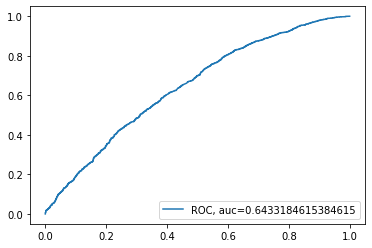

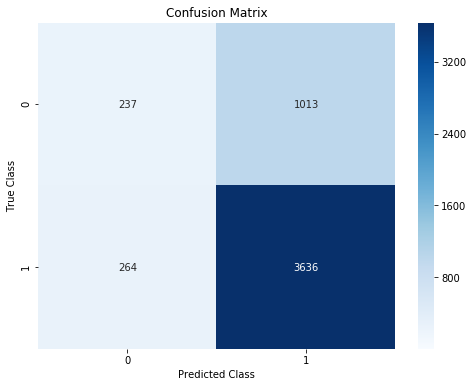

In [12]:
fig = plt.figure()
y_pred_proba = model.predict_proba(dfv3.drop(columns = 'TimeCycle'))[::,1]
fpr, tpr, _ = metrics.roc_curve(dfv3['TimeCycle'],y_pred_proba)
auc = metrics.roc_auc_score(dfv3['TimeCycle'], y_pred_proba)
plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
plt.legend(loc=4)
plt.show()
fig.savefig(dest+'fig3.png', dpi=fig.dpi)

cm = metrics.confusion_matrix(dfv3['TimeCycle'],result)
# labels = ['No Default', 'Default']
fig = plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()
fig.savefig(dest+'fig4.png', dpi=fig.dpi)

### Plotting shap plots to check positive or negetive quantities of effect of the individual features for the final prediction

In [53]:
shap_values = model.get_feature_importance(Pool(dfv3.drop(columns = ['TimeCycle']), label=dfv3['TimeCycle']),type="ShapValues")
# shap_values = model.get_feature_importance(Pool(X_test, label=y_test),type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.initjs()
shap.force_plot(expected_value, shap_values[2,:], X_test.iloc[2,:])

In [80]:
shap.initjs()
i = 16
shap.force_plot(expected_value,shap_values[i,:],dfv3.drop(columns = ['TimeCycle']).iloc[i,:])

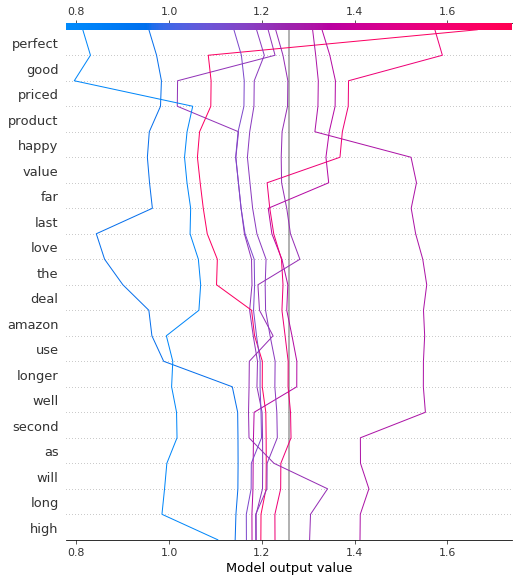

In [62]:
shap.decision_plot(expected_value,shap_values[20:30,:],dfv3.drop(columns = ['TimeCycle']).iloc[20:30,:], feature_names = list(dfv3.columns[:-1]))

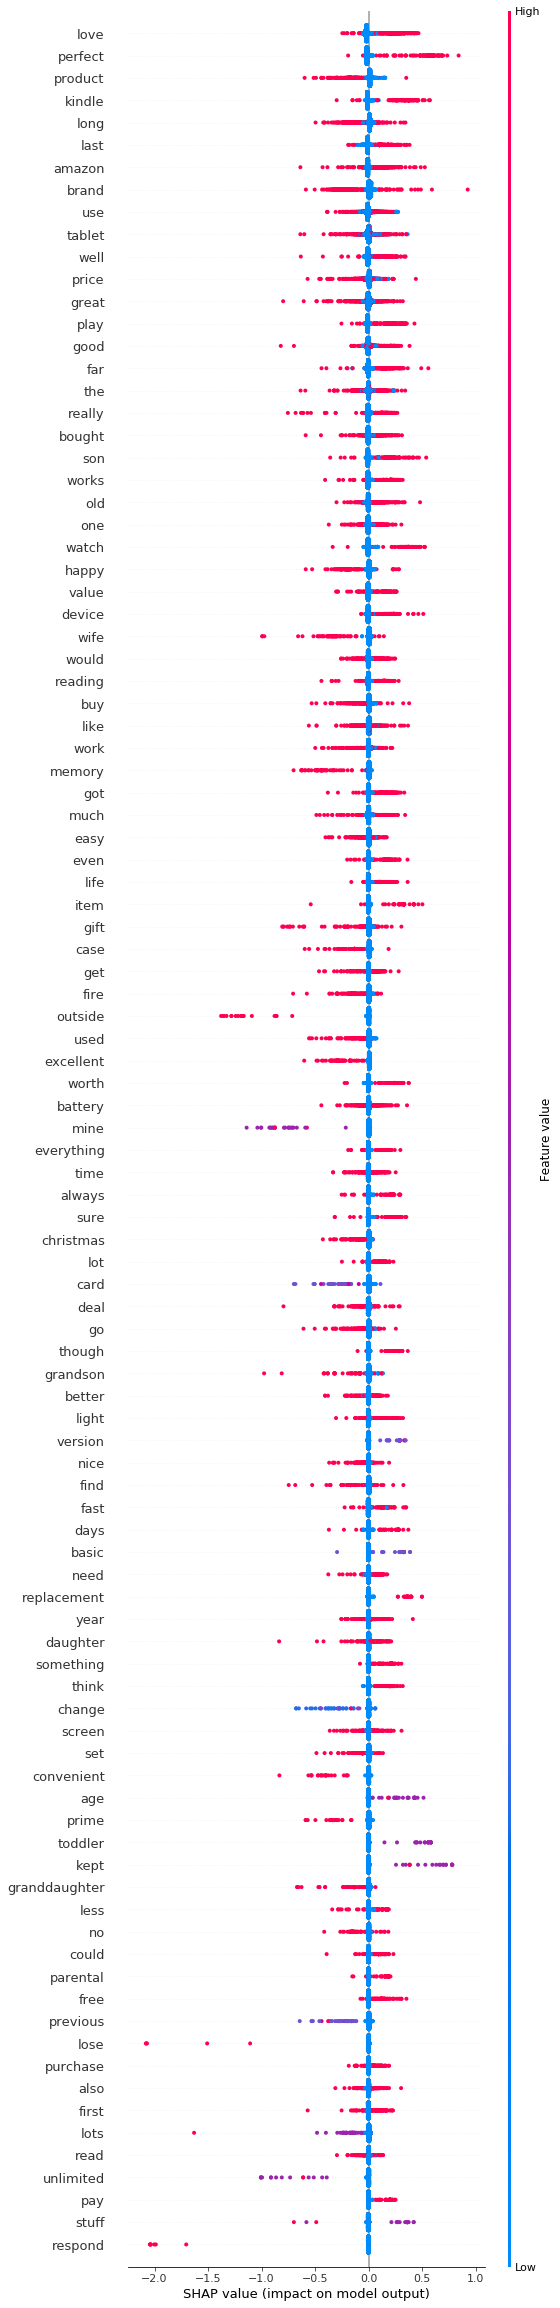

In [34]:
shap.summary_plot(shap_values, X_test, max_display = 100)

In [43]:
len(shap_values[1])
# len(X_test[1])

5136

### Saving features importances into csv

In [ ]:
df5 = pd.DataFrame(data = {'Features': dft3.drop(columns = 'TimeCycle').columns, 'Importances':model.get_feature_importance()}).sort_values(by = 'Importances', ascending = False)
df5.to_csv(dest+'Importances.csv')

## Point-Biscerial Correlations

In [94]:
from scipy import stats

l = []
for i in dft3:
    l2 = list(stats.pointbiserialr(dft3[i], dft3["TimeCycle"]))
    l2.append(i)
    l.append(l2)
    
# i = 'love'
# l2 = list(stats.pointbiserialr(dft3[i], dft3["TimeCycle"]))
# l2.append(i)

In [98]:
df_corr = pd.DataFrame(l)
df_corr.columns = ['Correlation', 'p.Value', 'Column']
df_corr = df_corr.set_index('Column')

df_corr[df_corr['p.Value'] <= 0.05].head()

,Correlation,p.Value
Column,,
aa,-0.001556,0.812689
abandon,0.003763,0.566746
ability,-0.008882,0.176279
able,0.002506,0.702824
abnormal,-0.011465,0.080879


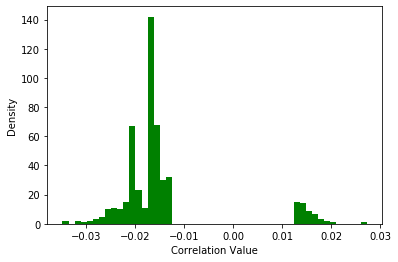

486

In [110]:
df_corr2 = df_corr[df_corr['p.Value'] <= 0.05]
df_corr3 = df_corr2[abs(df_corr2['Correlation']) < 0.8]
fig = plt.figure()
plt.hist(df_corr3['Correlation'], bins=50, color = 'g')
plt.xlabel('Correlation Value')
plt.ylabel('Density')
plt.show()
fig.savefig(dest+'fig5.png', dpi=fig.dpi)
df_corr3.shape[0]

In [111]:
df_corr3.to_csv("PB Corrs.csv")